In [172]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import glob
from thor.parallel import get_filepath_dicts, generate_time_intervals, get_tracked_objects, get_match_dicts, stitch_run
import thor.visualize as visualize
import thor.analyze as analyze
import thor.attribute as attribute
import thor.write as write

notebook_name = "cpol_demo.ipynb"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parallel

In [173]:
base_local = Path.home() / "THOR_output"
output_parent = base_local / "runs/cpol_demo_parallel"
start = "2005-11-13T13:00"
end = "2005-11-13T17:00"

pd_start = pd.Timestamp(start)

In [174]:
output_parent

PosixPath('/home/ewan/THOR_output/runs/cpol_demo_parallel')

In [175]:
intervals = generate_time_intervals(start, end)

In [187]:
options = analyze.utils.read_options(output_parent / "interval_0")
track_options = options["track"]
tracked_objects, all_objects = get_tracked_objects(track_options)

In [188]:
csv_file_dict, mask_file_dict = get_filepath_dicts(output_parent, intervals)

In [189]:
id_dicts = stitch_run(output_parent, intervals)

2024-10-04 22:30:54,925 - thor.parallel - INFO - Stitching attribute files.


2024-10-04 22:30:57,036 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/cpol_demo_parallel/attributes/anvil/core.csv
2024-10-04 22:30:57,043 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/cpol_demo_parallel/attributes/anvil/core.yml
2024-10-04 22:30:57,512 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/cpol_demo_parallel/attributes/anvil/era5_pl/profile.csv
2024-10-04 22:30:57,533 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/cpol_demo_parallel/attributes/anvil/era5_pl/profile.yml
2024-10-04 22:30:57,886 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/cpol_demo_parallel/attributes/anvil/era5_sl/tag.csv
2024-10-04 22:30:57,892 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/cpol_demo_parallel/attributes/anvil/era5_sl/tag.yml
2024

In [182]:
# Loop over objects
for k in range(len(mask_file_dict[0])):
    filepaths = [mask_file_dict[j][k] for j in range(len(intervals))]
    example_filepath = filepaths[0]
    masks = [xr.open_dataset(filepath) for filepath in filepaths]
    obj = Path(example_filepath).stem
    new_masks = []
    for i in range(len(intervals)):
        mask = masks[i]
        try:
            mapping = id_dicts[obj].xs(i, level="interval")
            id_type = list(mapping.columns)[0]
            mapping = mapping[id_type].to_dict()
        except KeyError:
            mapping = {}
        new_mask = mask.copy()
        for key in mapping.keys():
            for var in mask.data_vars:
                new_mask[var].values[mask[var].values == key] = mapping[key]
        if i < len(intervals) - 1:
            if masks[i + 1].time[0] != masks[i].time[-1]:
                raise ValueError("Time intervals have produced non-continuous masks")
            new_mask = new_mask.isel(time=slice(0, -1))
        new_masks.append(new_mask)
    mask = xr.concat(new_masks, dim="time")
    # for var in mask.data_vars:
    #     mask[var] = mask[var]
    filepath = Path(filepaths[0])
    filepath = Path(*[part for part in filepath.parts if part != "interval_0"])
    filepath.parent.mkdir(parents=True, exist_ok=True)
    # mask.to_netcdf(filepath)

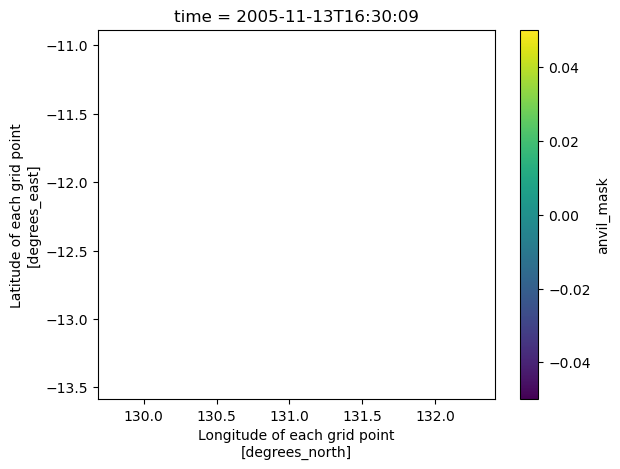

In [186]:
mask["anvil_mask"].isel(time=-4).plot()

In [155]:
mask.nbytes / 1e6

1.179136

In [135]:
np.unique(mask.isel(time=-1).values)

array([0, 3, 4])

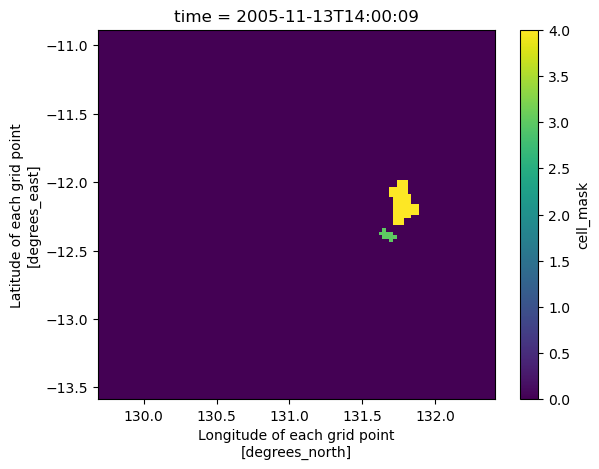

In [136]:
mask.isel(time=-1).plot()

In [119]:
new_mask = mask.copy()


1 3
2 4
3 7
4 8
5 9
6 10
7 11
8 12


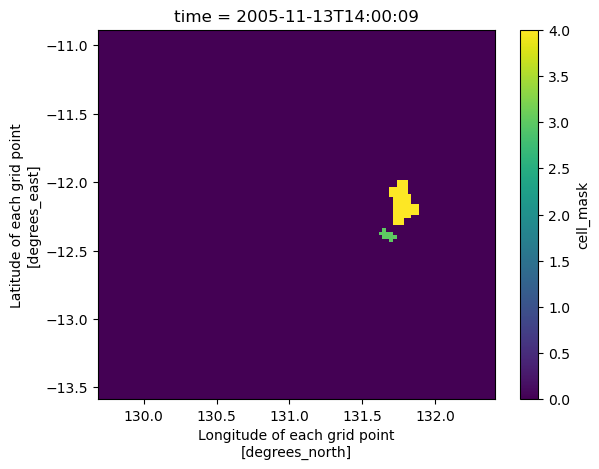

In [126]:
new_mask.isel(time=0).plot()

In [40]:
def apply_mapping(data_array, mapping):
    # Define a function that applies the mapping
    def map_func(value):
        return mapping.get(value, value)  # Return the mapped value or the original value if not in mapping

    # Apply the function to the DataArray using the map method
    return data_array.map(map_func)


In [41]:

# Example usage
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
data_array = xr.DataArray(data, dims=["x", "y"])

mapping = {1: 10, 2: 20, 3: 30, 4: 40, 5: 50, 6: 60, 7: 70, 8: 80, 9: 90}

transformed_array = apply_mapping(data_array, mapping)
print(transformed_array)

AttributeError: 'DataArray' object has no attribute 'map'

In [20]:
match_dicts

{0: {'anvil': {1: 1}, 'cell': {3: 1, 4: 2}, 'mcs': {}, 'middle_echo': None},
 1: {'anvil': {1: 1},
  'cell': {2: 2, 8: 3, 9: 1},
  'mcs': {1: 1},
  'middle_echo': None},
 2: {'anvil': {1: 1},
  'cell': {1: 1, 2: 3, 3: 4, 7: 2},
  'mcs': {1: 1},
  'middle_echo': None}}

In [359]:
stitch_attribute("quality", match_dicts, output_parent, intervals, "anvil", tracked_objects)

2024-10-04 18:31:26,021 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/cpol_demo_parallel/attributes/anvil/quality.csv
2024-10-04 18:31:26,028 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/cpol_demo_parallel/attributes/anvil/quality.yml


,universal_id,original_id,interval
0,0,1,0
4,0,1,1
10,0,1,2
16,0,1,3
20,1,2,3
23,2,3,3


2024-10-04 18:08:54,671 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/cpol_demo_parallel/attributes/cell/core.csv
2024-10-04 18:08:54,692 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/cpol_demo_parallel/attributes/cell/core.yml


latitude  longitude   area  u_flow  v_flow  \
time                universal_id                                               
2005-11-13 13:00:09 0              -12.525    132.300   60.1    -8.9     4.5   
                    1              -12.475    132.150   75.2    -8.9     9.0   
                    2              -12.375    132.200  203.0    -8.9     4.5   
                    3              -12.075    131.825   37.6    -6.6     4.5   
2005-11-13 13:10:23 1              -12.450    132.100   37.6    -9.3     4.7   
...                                    ...        ...    ...     ...     ...   
2005-11-13 16:40:09 26             -11.725    131.275   22.6    -6.8     2.3   
2005-11-13 16:50:08 3              -12.025    130.700  632.4    -9.1     4.6   
                    12             -12.400    130.975  308.2   -13.6    -0.0   
                    24             -11.800    130.800   15.1    -9.1    -0.0   
                    27             -12.325    130.700  233.1   -11.3    -0.0   

                                  u_displacement  v_displacement  
time                universal_id                                  
2005-11-13 13:00:09 0                        NaN             NaN  
                    1                       -8.9             4.5  
                    2                      -13.3             9.0  
                    3                       -4.4            -0.0  
2005-11-13 13:10:23 1                       13.9            18.9  
...                                          ...             ...  
2005-11-13 16:40:09 26                       NaN             NaN  
2005-11-13 16:50:08 3                       -9.1           -13.8  
                    12                     -13.6            -0.0  
                    24                       NaN             NaN  
                    27                       NaN             NaN  

[94 rows x 7 columns]

In [344]:
df

latitude  longitude   area  u_flow  v_flow  \
time                universal_id                                               
2005-11-13 13:00:09 0              -12.525    132.300   60.1    -8.9     4.5   
                    1              -12.475    132.150   75.2    -8.9     9.0   
                    2              -12.375    132.200  203.0    -8.9     4.5   
                    3              -12.075    131.825   37.6    -6.6     4.5   
2005-11-13 13:10:23 1              -12.450    132.100   37.6    -9.3     4.7   
...                                    ...        ...    ...     ...     ...   
2005-11-13 16:40:09 26             -11.725    131.275   22.6    -6.8     2.3   
2005-11-13 16:50:08 3              -12.025    130.700  632.4    -9.1     4.6   
                    12             -12.400    130.975  308.2   -13.6    -0.0   
                    24             -11.800    130.800   15.1    -9.1    -0.0   
                    27             -12.325    130.700  233.1   -11.3    -0.0   

                                  u_displacement  v_displacement  
time                universal_id                                  
2005-11-13 13:00:09 0                        NaN             NaN  
                    1                       -8.9             4.5  
                    2                      -13.3             9.0  
                    3                       -4.4            -0.0  
2005-11-13 13:10:23 1                       13.9            18.9  
...                                          ...             ...  
2005-11-13 16:40:09 26                       NaN             NaN  
2005-11-13 16:50:08 3                       -9.1           -13.8  
                    12                     -13.6            -0.0  
                    24                       NaN             NaN  
                    27                       NaN             NaN  

[94 rows x 7 columns]

In [ ]:


# for j in range(len(dfs)):
#     df = attribute.utils.read_attribute_csv(attr_filepath)
#     index_columns = list(df.index.names)
#     df = df.reset_index()
#     df["original_id"] = df["universal_id"]
#     ids = df["universal_id"].unique()
#     mag_ids = int(np.ceil(np.log10(len(ids)))) + 1
#     prefix = f"{str(j).zfill(mag_intervals)}_"
#     df["universal_id"] = df["universal_id"].astype(str)
#     df["universal_id"] = df["universal_id"].apply(lambda x: x.zfill(mag_ids))
#     df["universal_id"] = prefix + df["universal_id"]
#     df = df.set_index(index_columns)
#     dfs.append(df)
#     # convert universal id to str and prepend with interval number

In [302]:
match_dict = match_dicts[0][obj]
match_dict

{3: 1, 4: 2}

In [297]:
df

latitude  longitude   area  u_flow  v_flow  \
time                universal_id                                               
2005-11-13 13:00:09 00_01          -12.525    132.300   60.1    -8.9     4.5   
                    00_02          -12.475    132.150   75.2    -8.9     9.0   
                    00_03          -12.375    132.200  203.0    -8.9     4.5   
                    00_04          -12.075    131.825   37.6    -6.6     4.5   
2005-11-13 13:10:23 00_02          -12.450    132.100   37.6    -9.3     4.7   
...                                    ...        ...    ...     ...     ...   
2005-11-13 16:40:09 03_014         -11.725    131.275   22.6    -6.8     2.3   
2005-11-13 16:50:08 03_001         -12.400    130.975  308.2   -13.6    -0.0   
                    03_003         -12.025    130.700  632.4    -9.1     4.6   
                    03_012         -11.800    130.800   15.1    -9.1    -0.0   
                    03_015         -12.325    130.700  233.1   -11.3    -0.0   

                                  u_displacement  v_displacement  
time                universal_id                                  
2005-11-13 13:00:09 00_01                    NaN             NaN  
                    00_02                   -8.9             4.5  
                    00_03                  -13.3             9.0  
                    00_04                   -4.4            -0.0  
2005-11-13 13:10:23 00_02                   13.9            18.9  
...                                          ...             ...  
2005-11-13 16:40:09 03_014                   NaN             NaN  
2005-11-13 16:50:08 03_001                 -13.6            -0.0  
                    03_003                  -9.1           -13.8  
                    03_012                   NaN             NaN  
                    03_015                   NaN             NaN  

[94 rows x 7 columns]

In [290]:
match_dict_i = match_dicts[]

{0: {'anvil': {1: 1}, 'cell': {3: 1, 4: 2}, 'mcs': {}, 'middle_echo': None},
 1: {'anvil': {1: 1},
  'cell': {2: 2, 8: 3, 9: 1},
  'mcs': {1: 1},
  'middle_echo': None},
 2: {'anvil': {1: 1},
  'cell': {1: 1, 2: 3, 3: 4, 7: 2},
  'mcs': {1: 1},
  'middle_echo': None}}

In [239]:
filepaths_1, filepaths_2 = mask_file_dict[0], mask_file_dict[1]
objects_1 = [Path(filepath).stem for filepath in filepaths_1]
objects_2 = [Path(filepath).stem for filepath in filepaths_1]

tracked_objects = get_tracked_objects(track_options)

In [243]:
tracked_objects

['cell', 'anvil', 'mcs']

In [209]:
def match_all_objects(filepaths_1, filepaths_2):
    """Match all objects in two sets of files corresponding to two intervals."""
    match_dicts = {}
    objects_1 = [Path(filepath).stem for filepath in filepaths_1]
    objects_2 = [Path(filepath).stem for filepath in filepaths_1]

# Analysis

In [4]:
analysis_options = analyze.mcs.analysis_options()
analyze.mcs.process_velocities(output_directory)
analyze.mcs.quality_control(output_directory, analysis_options)
analyze.mcs.classify_all(output_directory)

2024-10-03 16:11:10,765 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/cpol_demo_geographic/analysis/velocities.csv
2024-10-03 16:11:10,768 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/cpol_demo_geographic/analysis/velocities.yml
2024-10-03 16:11:10,900 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/cpol_demo_geographic/analysis/quality.csv
2024-10-03 16:11:10,903 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/cpol_demo_geographic/analysis/quality.yml
2024-10-03 16:11:10,962 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/cpol_demo_geographic/analysis/classification.csv
2024-10-03 16:11:10,964 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/cpol_demo_geographic/analysis/classification.yml


,,stratiform_offset,inflow,relative_stratiform_offset,tilt,propagation
time,universal_id,,,,,
2005-11-13 16:00:08,1,trailing,front,trailing,up-shear,down-shear
2005-11-13 16:10:23,1,trailing,front,trailing,up-shear,down-shear
2005-11-13 16:20:09,1,trailing,front,trailing,up-shear,down-shear
2005-11-13 16:30:09,1,trailing,front,trailing,up-shear,down-shear
2005-11-13 16:40:09,1,trailing,front,trailing,up-shear,down-shear
2005-11-13 16:50:08,1,trailing,front,trailing,up-shear,down-shear
2005-11-13 17:00:08,1,trailing,front,trailing,up-shear,down-shear
2005-11-13 17:10:23,1,trailing,front,trailing,up-shear,down-shear
2005-11-13 17:20:09,1,trailing,front,trailing,up-shear,down-shear


In [7]:
figure_options = visualize.option.horizontal_attribute_options(
    "mcs_velocity_analysis", style="paper"
)
start_time = np.datetime64("2005-11-13T16:00")
end_time = np.datetime64("2005-11-13T19:00")
visualize.attribute.mcs_series(output_directory, start_time, end_time, figure_options)

2024-10-03 16:20:09,966 - thor.data.aura - INFO - Converting cpol data from twp10cpolgrid150.b2.20051113.160000.nc
2024-10-03 16:20:10,011 - thor.data.aura - INFO - Creating new geographic grid with spacing 0.025 m, 0.025 m.
2024-10-03 16:20:10,463 - thor.visualize.horizontal - INFO - No figsize provided. Using default.
2024-10-03 16:20:10,565 - thor.visualize.horizontal - DEBUG - Plotting boundary.
2024-10-03 16:20:10,583 - thor.visualize.horizontal - DEBUG - Plotting boundary.
2024-10-03 16:20:10,677 - thor.visualize.attribute - DEBUG - Saving mcs_velocity_analysis figure for 2005-11-13T16:00:08.000000000.
2024-10-03 16:20:12,125 - thor.data.aura - INFO - Converting cpol data from twp10cpolgrid150.b2.20051113.161000.nc
2024-10-03 16:20:12,903 - thor.visualize.horizontal - INFO - No figsize provided. Using default.
2024-10-03 16:20:13,001 - thor.visualize.horizontal - DEBUG - Plotting boundary.
2024-10-03 16:20:13,056 - thor.visualize.horizontal - DEBUG - Plotting boundary.
2024-10-03